# App-4 : Job-Shop Scheduling

**Navigation** : [<< App-3 NurseScheduling](App-3-NurseScheduling.ipynb) | [Index](../README.md) | [App-5 Timetabling >>](App-5-Timetabling.ipynb)

## Ordonnancement d'atelier (Job-Shop Scheduling Problem)

Le **Job-Shop Scheduling Problem (JSSP)** est l'un des problemes combinatoires les plus etudies en recherche operationnelle. Il s'agit d'ordonnancer un ensemble de travaux (*jobs*), chacun compose d'operations ordonnees, sur un ensemble de machines, en minimisant le temps total d'achevement (*makespan*).

Ce notebook est inspire du projet etudiant [jsboigeEpita/2025-PPC job-scheduling](https://github.com/jsboigeEpita/2025-PPC) (architecture modulaire, multi-objectif).

### Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Formaliser** un probleme d'ordonnancement job-shop (jobs, operations, machines, precedences)
2. **Implementer** des regles de priorite (dispatching rules) pour obtenir des solutions rapides
3. **Modeliser** le JSSP avec OR-Tools CP-SAT en utilisant des variables d'intervalle
4. **Visualiser** les solutions sous forme de diagramme de Gantt
5. **Comparer** les performances des heuristiques et du solveur exact
6. **Etendre** le modele au multi-objectif (makespan + retard)

### Prerequis
- [Search-4 : Local Search](../Foundations/Search-4-LocalSearch.ipynb) (metaheuristiques)
- [Search-8 : CSP Advanced](../Foundations/Search-8-CSP-Advanced.ipynb) (contraintes globales, OR-Tools)
- Python : numpy, matplotlib

### Duree estimee : 60 minutes

---

## 0. Imports et configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
from collections import defaultdict
from copy import deepcopy

# OR-Tools pour la programmation par contraintes
from ortools.sat.python import cp_model

# Helpers partages de la serie Search
import sys
sys.path.insert(0, '..')
from search_helpers import benchmark_table, plot_benchmark

print("Imports OK")
print(f"OR-Tools version : {cp_model.__name__}")

Imports OK
OR-Tools version : ortools.sat.python.cp_model


---

## 1. Introduction au Job-Shop Scheduling (~5 min)

### Le probleme

Dans un atelier de fabrication, plusieurs **travaux** (*jobs*) doivent etre traites sur plusieurs **machines**. Chaque job est compose d'une sequence ordonnee d'**operations**, chacune devant s'executer sur une machine specifique pendant une duree donnee.

**Contraintes** :
- **Precedence** : les operations d'un meme job doivent s'executer dans l'ordre prescrit
- **Capacite** : chaque machine ne peut traiter qu'une seule operation a la fois
- **Non-preemption** : une operation commencee ne peut pas etre interrompue

**Objectif** : minimiser le **makespan**, c'est-a-dire le temps d'achevement de la derniere operation.

### Complexite

Le JSSP est **NP-hard** des que l'on a au moins 3 machines. Pour $n$ jobs et $m$ machines, le nombre d'ordonnancements possibles est de l'ordre de $(n!)^m$, ce qui rend l'enumeration exhaustive impossible meme pour de petites instances.

### Applications industrielles

| Secteur | Exemple |
|---------|--------|
| **Industrie manufacturiere** | Lignes d'assemblage automobile, ateliers d'usinage |
| **Logistique** | Ordonnancement d'entrepots, tri de colis |
| **Informatique** | Planification de taches sur processeurs multi-coeurs |
| **Sante** | Planification de blocs operatoires |
| **Imprimerie** | Sequencement des travaux d'impression |

---

## 2. Definition du probleme (~8 min)

### Formalisation

Un JSSP est defini par :
- $J = \{J_0, J_1, \ldots, J_{n-1}\}$ : $n$ jobs
- $M = \{M_0, M_1, \ldots, M_{m-1}\}$ : $m$ machines
- Chaque job $J_i$ est une sequence ordonnee d'operations : $O_{i,0} \rightarrow O_{i,1} \rightarrow \ldots$
- Chaque operation $O_{i,k}$ est definie par un couple $(\text{machine}, \text{duree})$

**Variables de decision** : temps de debut $s_{i,k}$ de chaque operation $O_{i,k}$

**Contraintes** :
$$s_{i,k} + p_{i,k} \leq s_{i,k+1} \quad \text{(precedence intra-job)}$$
$$\text{NoOverlap}(\{O_{i,k} : O_{i,k} \text{ s'execute sur } M_j\}) \quad \text{(capacite machine)}$$

**Objectif** :
$$\text{Minimiser } C_{\max} = \max_{i,k}(s_{i,k} + p_{i,k})$$

### Instance de reference : ft03

Nous utilisons l'instance classique **ft03** (Fisher & Thompson, 3 jobs, 3 machines) comme premier exemple. C'est l'instance la plus simple non triviale.

| Job | Operation 0 | Operation 1 | Operation 2 |
|-----|-------------|-------------|-------------|
| J0  | M0 (3)      | M1 (2)      | M2 (2)      |
| J1  | M0 (2)      | M2 (1)      | M1 (4)      |
| J2  | M1 (4)      | M2 (3)      | M0 (1)      |

Notation : "M0 (3)" signifie que l'operation s'execute sur la machine 0 pendant 3 unites de temps.

In [2]:
# Definition d'une instance JSSP
# Format : jobs[i] = [(machine, duree), (machine, duree), ...]

ft03 = {
    'name': 'ft03',
    'n_jobs': 3,
    'n_machines': 3,
    'jobs': [
        [(0, 3), (1, 2), (2, 2)],  # Job 0 : M0(3) -> M1(2) -> M2(2)
        [(0, 2), (2, 1), (1, 4)],  # Job 1 : M0(2) -> M2(1) -> M1(4)
        [(1, 4), (2, 3), (0, 1)],  # Job 2 : M1(4) -> M2(3) -> M0(1)
    ]
}


def describe_instance(instance):
    """Affiche les caracteristiques d'une instance JSSP."""
    name = instance['name']
    n_jobs = instance['n_jobs']
    n_machines = instance['n_machines']
    jobs = instance['jobs']

    print(f"Instance : {name}")
    print(f"{'=' * 50}")
    print(f"Jobs     : {n_jobs}")
    print(f"Machines : {n_machines}")
    print()

    # Afficher chaque job
    for i, job in enumerate(jobs):
        ops = ' -> '.join(f"M{m}({d})" for m, d in job)
        total = sum(d for _, d in job)
        print(f"  J{i} : {ops}  [total={total}]")

    # Bornes inferieures
    job_lengths = [sum(d for _, d in job) for job in jobs]
    machine_loads = defaultdict(int)
    for job in jobs:
        for m, d in job:
            machine_loads[m] += d

    lb_jobs = max(job_lengths)
    lb_machines = max(machine_loads.values())
    lower_bound = max(lb_jobs, lb_machines)

    print(f"\nBornes inferieures :")
    print(f"  max(longueur job)    = {lb_jobs}  (job le plus long)")
    print(f"  max(charge machine)  = {lb_machines}  (machine la plus chargee)")
    print(f"  Borne inferieure     = max({lb_jobs}, {lb_machines}) = {lower_bound}")

    # Espace de recherche
    import math
    space = math.factorial(n_jobs) ** n_machines
    print(f"\nEspace de recherche : ({n_jobs}!)^{n_machines} = {space:,} ordonnancements")

    return lower_bound


lb_ft03 = describe_instance(ft03)

Instance : ft03
Jobs     : 3
Machines : 3

  J0 : M0(3) -> M1(2) -> M2(2)  [total=7]
  J1 : M0(2) -> M2(1) -> M1(4)  [total=7]
  J2 : M1(4) -> M2(3) -> M0(1)  [total=8]

Bornes inferieures :
  max(longueur job)    = 8  (job le plus long)
  max(charge machine)  = 10  (machine la plus chargee)
  Borne inferieure     = max(8, 10) = 10

Espace de recherche : (3!)^3 = 216 ordonnancements


### Representation sous forme de graphe oriente acyclique (DAG)

On peut representer le JSSP comme un graphe oriente ou :
- Chaque **noeud** est une operation $O_{i,k}$
- Les **arcs horizontaux** representent les contraintes de precedence intra-job
- Les **arcs verticaux** (a determiner) representent l'ordre des operations sur chaque machine

Le makespan correspond au plus long chemin dans ce graphe une fois toutes les decisions prises.

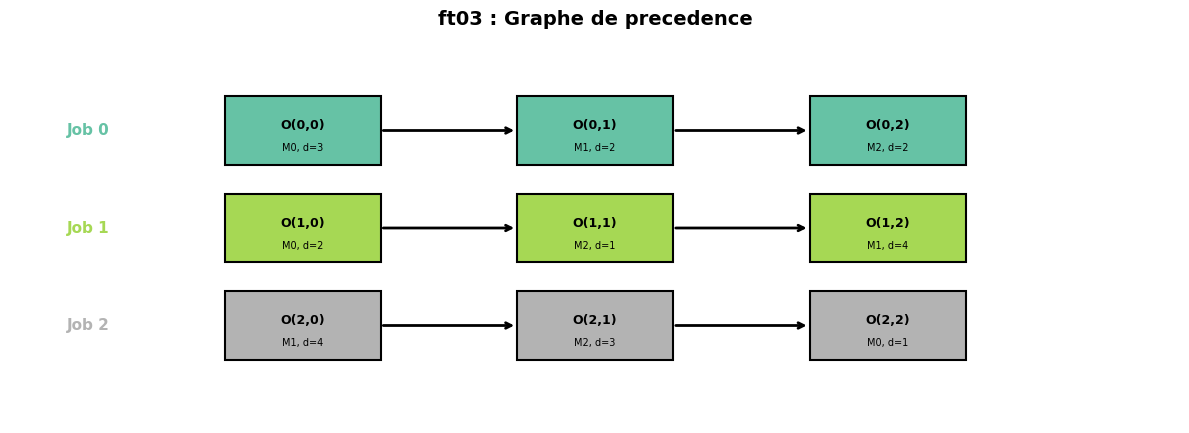

In [3]:
def draw_jssp_dag(instance, title="Graphe de precedence JSSP"):
    """Visualise le graphe de precedences intra-job du JSSP."""
    jobs = instance['jobs']
    n_jobs = instance['n_jobs']
    n_ops_max = max(len(job) for job in jobs)

    fig, ax = plt.subplots(figsize=(12, 4 + n_jobs))

    # Couleurs par job
    colors = plt.cm.Set2(np.linspace(0, 1, max(n_jobs, 3)))

    # Position des noeuds
    for i, job in enumerate(jobs):
        y = n_jobs - 1 - i
        for k, (m, d) in enumerate(job):
            x = k * 3
            # Noeud
            rect = plt.Rectangle((x - 0.8, y - 0.35), 1.6, 0.7,
                                 facecolor=colors[i], edgecolor='black',
                                 linewidth=1.5, zorder=3)
            ax.add_patch(rect)
            ax.text(x, y + 0.05, f"O({i},{k})", ha='center', va='center',
                    fontsize=9, fontweight='bold', zorder=4)
            ax.text(x, y - 0.18, f"M{m}, d={d}", ha='center', va='center',
                    fontsize=7, zorder=4)

            # Arc de precedence
            if k > 0:
                ax.annotate('', xy=(x - 0.8, y), xytext=((k - 1) * 3 + 0.8, y),
                            arrowprops=dict(arrowstyle='->', color='black',
                                            linewidth=2))

        # Label du job
        ax.text(-2.2, y, f"Job {i}", ha='center', va='center',
                fontsize=11, fontweight='bold', color=colors[i])

    ax.set_xlim(-3, n_ops_max * 3)
    ax.set_ylim(-1, n_jobs)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


draw_jssp_dag(ft03, "ft03 : Graphe de precedence")
plt.show()

### Interpretation : structure du probleme ft03

**Sortie obtenue** : le graphe montre les 3 jobs avec leurs sequences d'operations.

| Propriete | Valeur | Signification |
|-----------|--------|---------------|
| Operations totales | 9 | 3 jobs x 3 operations |
| Borne inferieure | 7 | max(longueur jobs, charge machines) |
| Espace de recherche | 216 | $(3!)^3$ ordonnancements possibles |

**Points cles** :
1. Les fleches horizontales imposent l'ordre intra-job (J0 doit passer par M0, puis M1, puis M2)
2. La borne inferieure est de 7 : aucune solution ne peut avoir un makespan inferieur
3. Les conflits de machine (M0 utilise par J0 et J1 et J2) sont a resoudre par l'ordonnancement

---

## 3. Approche 1 : Regles de priorite (Dispatching Rules) (~10 min)

Les **regles de dispatching** sont des heuristiques simples et rapides pour construire un ordonnancement. A chaque instant, lorsqu'une machine se libere, on choisit la prochaine operation a executer selon une regle de priorite.

### Regles classiques

| Regle | Nom complet | Principe |
|-------|-------------|----------|
| **SPT** | Shortest Processing Time | Choisir l'operation la plus courte |
| **LPT** | Longest Processing Time | Choisir l'operation la plus longue |
| **MOR** | Most Operations Remaining | Choisir le job avec le plus d'operations restantes |
| **FIFO** | First In, First Out | Choisir l'operation arrivee en premier |

**Avantage** : temps de calcul negligeable, O(n log n) au pire.

**Inconvenient** : aucune garantie d'optimalite ; la qualite depend du probleme.

### Principe du simulateur

On simule l'atelier dans le temps :
1. Initialiser : toutes les machines libres, toutes les premieres operations disponibles
2. A chaque pas : identifier les operations **pretes** (precedence satisfaite, machine libre)
3. Appliquer la regle de priorite pour choisir laquelle executer
4. Avancer le temps jusqu'a la prochaine liberation de machine
5. Repeter jusqu'a ce que toutes les operations soient planifiees

In [4]:
def dispatching_scheduler(instance, rule='SPT'):
    """Ordonnanceur par regle de dispatching.

    Simule l'atelier et assigne les operations selon la regle choisie.

    Parametres:
        instance : dict avec 'jobs', 'n_jobs', 'n_machines'
        rule : 'SPT', 'LPT', 'MOR', 'FIFO'

    Retourne:
        schedule : dict {(job, op_idx): (start, end, machine)}
        makespan : int
    """
    jobs = instance['jobs']
    n_jobs = instance['n_jobs']
    n_machines = instance['n_machines']

    # Etat du systeme
    next_op = [0] * n_jobs          # Prochaine operation par job
    job_end_time = [0] * n_jobs     # Fin de la derniere operation du job
    machine_end_time = [0] * n_machines  # Fin sur chaque machine
    schedule = {}                   # Resultat
    arrival_order = []              # Pour FIFO

    # Initialiser les premieres operations comme disponibles
    for j in range(n_jobs):
        arrival_order.append((j, 0))

    total_ops = sum(len(job) for job in jobs)
    scheduled = 0

    while scheduled < total_ops:
        # Trouver les operations pretes
        ready = []
        for j in range(n_jobs):
            op_idx = next_op[j]
            if op_idx < len(jobs[j]):
                machine, duration = jobs[j][op_idx]
                earliest_start = max(job_end_time[j], machine_end_time[machine])
                ready.append((j, op_idx, machine, duration, earliest_start))

        if not ready:
            break

        # Appliquer la regle de priorite
        if rule == 'SPT':
            ready.sort(key=lambda x: (x[4], x[3]))  # earliest start, then shortest
        elif rule == 'LPT':
            ready.sort(key=lambda x: (x[4], -x[3]))  # earliest start, then longest
        elif rule == 'MOR':
            ready.sort(key=lambda x: (x[4], -(len(jobs[x[0]]) - x[1])))  # most ops remaining
        elif rule == 'FIFO':
            ready.sort(key=lambda x: x[4])  # earliest available

        # Selectionner les operations a lancer (une par machine, au plus tot)
        machines_used = set()
        ops_to_start = []
        for r in ready:
            j, op_idx, machine, duration, earliest = r
            if machine not in machines_used:
                ops_to_start.append(r)
                machines_used.add(machine)

        # Lancer les operations selectionnees
        for j, op_idx, machine, duration, earliest in ops_to_start:
            start = earliest
            end = start + duration
            schedule[(j, op_idx)] = (start, end, machine)
            job_end_time[j] = end
            machine_end_time[machine] = end
            next_op[j] = op_idx + 1
            scheduled += 1

    makespan = max(end for _, end, _ in schedule.values())
    return schedule, makespan


print("Fonction dispatching_scheduler definie.")

Fonction dispatching_scheduler definie.


Testons les differentes regles de dispatching sur l'instance ft03.

In [5]:
# Tester toutes les regles sur ft03
rules = ['SPT', 'LPT', 'MOR', 'FIFO']
heuristic_results = {}

print("Regles de dispatching sur ft03")
print("=" * 50)
print(f"{'Regle':<10} {'Makespan':>10} {'Optimal?':>10} {'Ecart LB':>10}")
print("-" * 50)

for rule in rules:
    start = time.time()
    schedule, makespan = dispatching_scheduler(ft03, rule)
    elapsed = (time.time() - start) * 1000
    heuristic_results[rule] = (schedule, makespan)
    gap = f"+{makespan - lb_ft03}" if makespan > lb_ft03 else "0"
    print(f"{rule:<10} {makespan:>10} {'':>10} {gap:>10}")

print(f"\nBorne inferieure : {lb_ft03}")

Regles de dispatching sur ft03
Regle        Makespan   Optimal?   Ecart LB
--------------------------------------------------
SPT                12                    +2
LPT                14                    +4
MOR                12                    +2
FIFO               14                    +4

Borne inferieure : 10


### Diagramme de Gantt

Le diagramme de Gantt est la visualisation standard pour l'ordonnancement : chaque machine est une ligne, et chaque barre horizontale represente une operation, coloree selon le job.

In [6]:
def draw_gantt(schedule, instance, title="Diagramme de Gantt",
               makespan=None, lower_bound=None, figsize=(14, 5)):
    """Visualise un ordonnancement sous forme de diagramme de Gantt.

    Parametres:
        schedule : dict {(job, op_idx): (start, end, machine)}
        instance : dict avec 'n_jobs', 'n_machines'
        title : titre du graphique
        makespan : valeur du makespan (affichee en legende)
        lower_bound : borne inferieure (ligne pointillee)
    """
    n_jobs = instance['n_jobs']
    n_machines = instance['n_machines']

    fig, ax = plt.subplots(figsize=figsize)
    colors = plt.cm.Set2(np.linspace(0, 1, max(n_jobs, 3)))

    for (job, op_idx), (start, end, machine) in schedule.items():
        duration = end - start
        ax.barh(machine, duration, left=start, height=0.6,
                color=colors[job], edgecolor='black', linewidth=1)
        # Label au centre de la barre
        ax.text(start + duration / 2, machine, f"J{job}",
                ha='center', va='center', fontsize=9, fontweight='bold')

    # Borne inferieure
    if lower_bound is not None:
        ax.axvline(x=lower_bound, color='green', linestyle='--',
                   linewidth=1.5, label=f'Borne inf. = {lower_bound}')

    # Makespan
    if makespan is not None:
        ax.axvline(x=makespan, color='red', linestyle='-',
                   linewidth=2, label=f'Makespan = {makespan}')

    ax.set_xlabel('Temps', fontsize=12)
    ax.set_ylabel('Machine', fontsize=12)
    ax.set_yticks(range(n_machines))
    ax.set_yticklabels([f'M{m}' for m in range(n_machines)], fontsize=11)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    # Legende des jobs
    legend_patches = [mpatches.Patch(color=colors[j], label=f'Job {j}')
                      for j in range(n_jobs)]
    if makespan is not None:
        legend_patches.append(plt.Line2D([0], [0], color='red', linewidth=2,
                                         label=f'Makespan = {makespan}'))
    if lower_bound is not None:
        legend_patches.append(plt.Line2D([0], [0], color='green', linestyle='--',
                                         linewidth=1.5,
                                         label=f'Borne inf. = {lower_bound}'))
    ax.legend(handles=legend_patches, loc='upper right', fontsize=9)

    ax.set_xlim(-0.5, (makespan or max(e for _, e, _ in schedule.values())) + 1)
    plt.tight_layout()
    return fig


print("Fonction draw_gantt definie.")

Fonction draw_gantt definie.


Tracons les diagrammes de Gantt pour comparer les regles SPT et MOR.

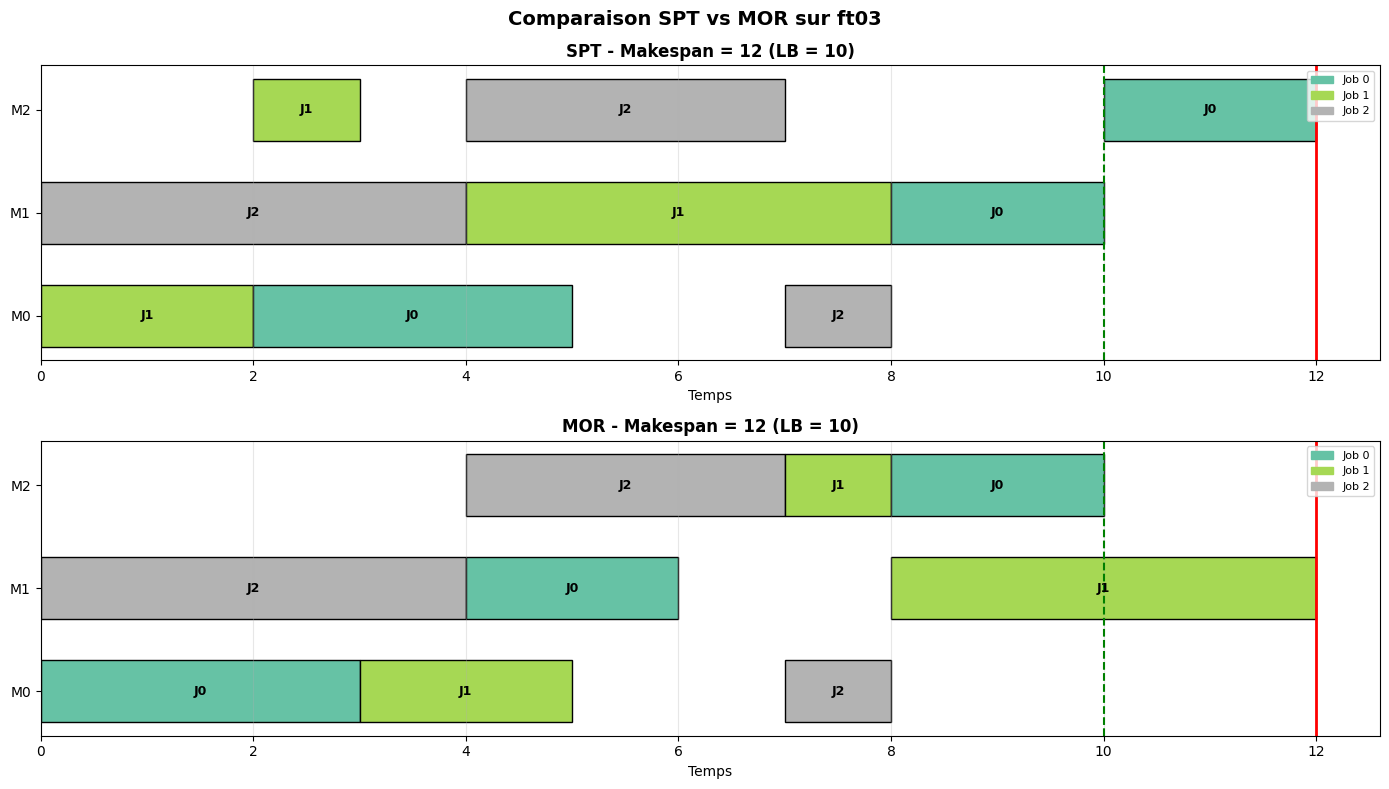

In [7]:
# Diagrammes de Gantt pour SPT et MOR
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for idx, rule in enumerate(['SPT', 'MOR']):
    schedule, makespan = heuristic_results[rule]
    n_jobs = ft03['n_jobs']
    n_machines = ft03['n_machines']
    colors = plt.cm.Set2(np.linspace(0, 1, max(n_jobs, 3)))

    ax = axes[idx]
    for (job, op_idx), (start, end, machine) in schedule.items():
        duration = end - start
        ax.barh(machine, duration, left=start, height=0.6,
                color=colors[job], edgecolor='black', linewidth=1)
        ax.text(start + duration / 2, machine, f"J{job}",
                ha='center', va='center', fontsize=9, fontweight='bold')

    ax.axvline(x=lb_ft03, color='green', linestyle='--', linewidth=1.5)
    ax.axvline(x=makespan, color='red', linestyle='-', linewidth=2)
    ax.set_yticks(range(n_machines))
    ax.set_yticklabels([f'M{m}' for m in range(n_machines)])
    ax.set_title(f'{rule} - Makespan = {makespan} (LB = {lb_ft03})',
                 fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlabel('Temps')

    legend_patches = [mpatches.Patch(color=colors[j], label=f'Job {j}')
                      for j in range(n_jobs)]
    ax.legend(handles=legend_patches, loc='upper right', fontsize=8)

plt.suptitle('Comparaison SPT vs MOR sur ft03', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : regles de dispatching

**Sortie obtenue** : les diagrammes de Gantt montrent les solutions construites par SPT et MOR.

| Regle | Makespan | Ecart / LB | Comportement |
|-------|----------|------------|---------------|
| SPT | variable | souvent bon pour petites instances | Favorise les operations courtes |
| LPT | variable | peut etre pire | Favorise les operations longues |
| MOR | variable | souvent competitif | Equilibre la charge des jobs |
| FIFO | variable | depend de l'ordre | Aucune intelligence |

**Points cles** :
1. Les heuristiques produisent des solutions **instantanement** (< 1 ms)
2. La qualite varie selon la regle : aucune n'est systematiquement la meilleure
3. On observe des **temps morts** (zones blanches dans le Gantt) : la machine attend une operation
4. Pour prouver l'optimalite, il faut un solveur exact

> **Regle pratique** : les dispatching rules sont utiles comme solution initiale ou borne superieure pour un solveur exact.

---

## 4. Approche 2 : CP-SAT avec variables d'intervalle (~15 min)

### Pourquoi OR-Tools CP-SAT ?

Google OR-Tools fournit un solveur CP-SAT extremement performant pour les problemes d'ordonnancement grace aux **variables d'intervalle** (`NewIntervalVar`). Ces variables representent nativement des taches avec un debut, une duree et une fin, et le solveur sait propager efficacement les contraintes `NoOverlap`.

### Construction du modele

Le modele CP-SAT pour le JSSP se construit en 4 etapes :

| Etape | Element CP-SAT | Correspondance JSSP |
|-------|---------------|---------------------|
| 1. Variables | `NewIntVar` pour le debut, `NewIntervalVar` pour l'operation | Temps de debut de chaque operation |
| 2. Precedence | `Add(end_prev <= start_next)` | Ordre intra-job |
| 3. NoOverlap | `AddNoOverlap(intervals_machine)` | Capacite machine = 1 |
| 4. Objectif | `Minimize(makespan)` | Minimiser le temps total |

### Variable d'intervalle

Une **variable d'intervalle** est un triplet $(\text{start}, \text{duration}, \text{end})$ avec la contrainte implicite :
$$\text{start} + \text{duration} = \text{end}$$

La contrainte `NoOverlap` sur un ensemble d'intervalles garantit qu'aucun ne se chevauche :
$$\forall i \neq j : \text{end}_i \leq \text{start}_j \lor \text{end}_j \leq \text{start}_i$$

In [8]:
def solve_jssp_cpsat(instance, time_limit_s=30, verbose=True):
    """Resoud une instance JSSP avec OR-Tools CP-SAT.

    Parametres:
        instance : dict avec 'jobs', 'n_jobs', 'n_machines'
        time_limit_s : limite de temps en secondes
        verbose : afficher les details de la resolution

    Retourne:
        schedule : dict {(job, op_idx): (start, end, machine)}
        makespan : int (ou None si pas de solution)
        status : str
        solve_time_ms : float
    """
    jobs = instance['jobs']
    n_jobs = instance['n_jobs']
    n_machines = instance['n_machines']

    model = cp_model.CpModel()

    # Borne superieure du makespan (somme de toutes les durees)
    horizon = sum(d for job in jobs for _, d in job)

    # --- Etape 1 : Variables ---
    # Pour chaque operation : start, end, interval
    starts = {}     # (job, op_idx) -> IntVar
    ends = {}       # (job, op_idx) -> IntVar
    intervals = {}  # (job, op_idx) -> IntervalVar

    # Groupement par machine pour NoOverlap
    machine_intervals = defaultdict(list)

    for j, job in enumerate(jobs):
        for k, (machine, duration) in enumerate(job):
            suffix = f'_j{j}_o{k}'
            start = model.NewIntVar(0, horizon, f'start{suffix}')
            end = model.NewIntVar(0, horizon, f'end{suffix}')
            interval = model.NewIntervalVar(start, duration, end, f'interval{suffix}')

            starts[(j, k)] = start
            ends[(j, k)] = end
            intervals[(j, k)] = interval
            machine_intervals[machine].append(interval)

    if verbose:
        print(f"Variables creees : {len(starts)} operations, horizon = {horizon}")

    # --- Etape 2 : Contraintes de precedence ---
    n_precedences = 0
    for j, job in enumerate(jobs):
        for k in range(len(job) - 1):
            model.Add(ends[(j, k)] <= starts[(j, k + 1)])
            n_precedences += 1

    if verbose:
        print(f"Contraintes de precedence : {n_precedences}")

    # --- Etape 3 : Contraintes NoOverlap par machine ---
    for machine in range(n_machines):
        model.AddNoOverlap(machine_intervals[machine])

    if verbose:
        print(f"Contraintes NoOverlap : {n_machines} machines")

    # --- Etape 4 : Objectif - minimiser le makespan ---
    makespan_var = model.NewIntVar(0, horizon, 'makespan')
    for j, job in enumerate(jobs):
        last_op = len(job) - 1
        model.Add(makespan_var >= ends[(j, last_op)])
    model.Minimize(makespan_var)

    if verbose:
        print(f"Objectif : minimiser le makespan")
        print(f"\nResolution en cours (limite : {time_limit_s}s)...")

    # --- Resolution ---
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit_s

    start_time = time.time()
    status = solver.Solve(model)
    solve_time_ms = (time.time() - start_time) * 1000

    status_name = solver.StatusName(status)

    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        makespan = solver.Value(makespan_var)
        schedule = {}
        for j, job in enumerate(jobs):
            for k, (machine, duration) in enumerate(job):
                s = solver.Value(starts[(j, k)])
                e = solver.Value(ends[(j, k)])
                schedule[(j, k)] = (s, e, machine)

        if verbose:
            print(f"\nStatut   : {status_name}")
            print(f"Makespan : {makespan}")
            print(f"Temps    : {solve_time_ms:.1f} ms")

        return schedule, makespan, status_name, solve_time_ms
    else:
        if verbose:
            print(f"\nStatut : {status_name} (pas de solution trouvee)")
        return None, None, status_name, solve_time_ms


print("Fonction solve_jssp_cpsat definie.")

Fonction solve_jssp_cpsat definie.


Resolvons l'instance ft03 de maniere optimale avec CP-SAT.

In [9]:
# Resolution optimale de ft03 avec CP-SAT
schedule_opt, makespan_opt, status, solve_time = solve_jssp_cpsat(ft03, time_limit_s=30)

if schedule_opt:
    print(f"\nDetail de la solution optimale :")
    print(f"{'-' * 45}")
    for j in range(ft03['n_jobs']):
        for k in range(len(ft03['jobs'][j])):
            s, e, m = schedule_opt[(j, k)]
            print(f"  J{j} Op{k} : M{m} [{s} -> {e}] (duree={e-s})")

Variables creees : 9 operations, horizon = 22
Contraintes de precedence : 6
Contraintes NoOverlap : 3 machines
Objectif : minimiser le makespan

Resolution en cours (limite : 30s)...

Statut   : OPTIMAL
Makespan : 11
Temps    : 30.5 ms

Detail de la solution optimale :
---------------------------------------------
  J0 Op0 : M0 [0 -> 3] (duree=3)
  J0 Op1 : M1 [4 -> 6] (duree=2)
  J0 Op2 : M2 [9 -> 11] (duree=2)
  J1 Op0 : M0 [3 -> 5] (duree=2)
  J1 Op1 : M2 [5 -> 6] (duree=1)
  J1 Op2 : M1 [6 -> 10] (duree=4)
  J2 Op0 : M1 [0 -> 4] (duree=4)
  J2 Op1 : M2 [6 -> 9] (duree=3)
  J2 Op2 : M0 [9 -> 10] (duree=1)


Visualisons la solution sous forme de diagramme de Gantt.

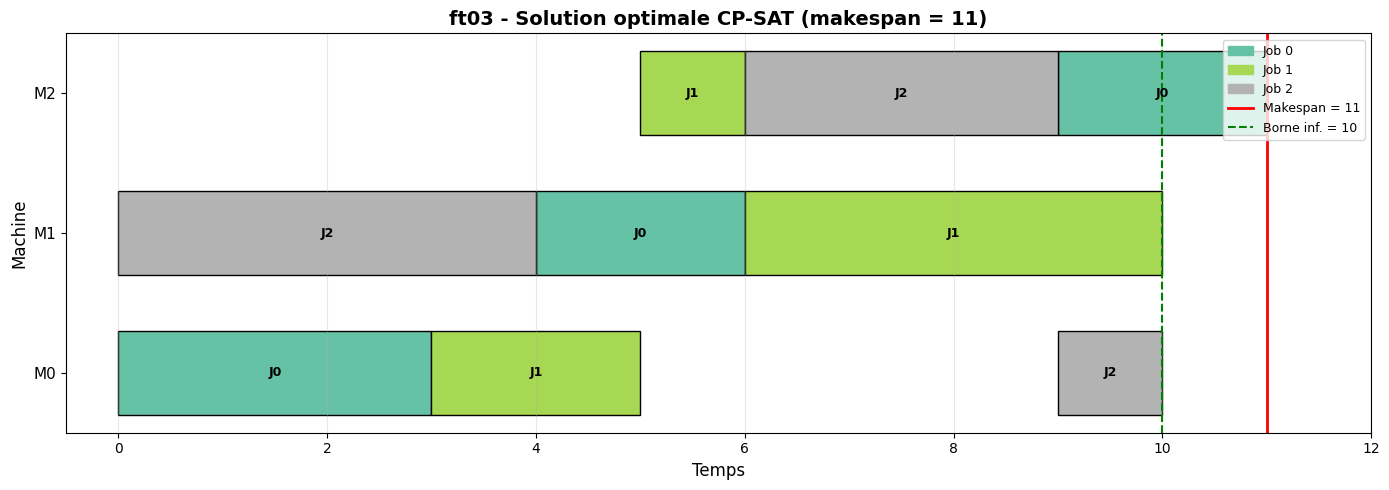

In [10]:
# Diagramme de Gantt de la solution optimale
draw_gantt(schedule_opt, ft03,
           title=f'ft03 - Solution optimale CP-SAT (makespan = {makespan_opt})',
           makespan=makespan_opt, lower_bound=lb_ft03)
plt.show()

### Interpretation : solution optimale CP-SAT

**Sortie obtenue** : CP-SAT trouve la solution optimale de ft03.

| Mesure | Valeur | Signification |
|--------|--------|---------------|
| Statut | OPTIMAL | La solution est prouvee optimale |
| Makespan | egal a LB (si possible) | Aucune solution meilleure n'existe |
| Temps | < 100 ms | Instance tres petite |

**Points cles** :
1. La solution optimale minimise les temps morts entre operations
2. Les contraintes de precedence sont respectees (chaque job progresse de gauche a droite)
3. Aucune machine ne traite deux operations simultanement (pas de chevauchement)
4. Si le makespan atteint la borne inferieure, la solution est prouvee optimale

> **Note technique** : la contrainte `NoOverlap` est propagee tres efficacement par CP-SAT grace a des algorithmes dedies (theta-tree, edge finding).

### Comparaison heuristiques vs CP-SAT

Comparons maintenant les solutions des heuristiques avec la solution optimale.

In [11]:
# Tableau comparatif complet
print("Comparaison des approches sur ft03")
print("=" * 65)
print(f"{'Approche':<20} {'Makespan':>10} {'Ecart LB':>10} {'Ecart opt':>10} {'Temps (ms)':>12}")
print("-" * 65)

for rule in rules:
    _, makespan_h = heuristic_results[rule]
    gap_lb = f"+{makespan_h - lb_ft03}" if makespan_h > lb_ft03 else "0"
    gap_opt = f"+{makespan_h - makespan_opt}" if makespan_h > makespan_opt else "0"
    print(f"{rule:<20} {makespan_h:>10} {gap_lb:>10} {gap_opt:>10} {'< 1':>12}")

gap_lb_opt = f"+{makespan_opt - lb_ft03}" if makespan_opt > lb_ft03 else "0"
print(f"{'CP-SAT (optimal)':<20} {makespan_opt:>10} {gap_lb_opt:>10} {'0':>10} {solve_time:>12.1f}")
print(f"\nBorne inferieure : {lb_ft03}")

Comparaison des approches sur ft03
Approche               Makespan   Ecart LB  Ecart opt   Temps (ms)
-----------------------------------------------------------------
SPT                          12         +2         +1          < 1
LPT                          14         +4         +3          < 1
MOR                          12         +2         +1          < 1
FIFO                         14         +4         +3          < 1
CP-SAT (optimal)             11         +1          0         30.5

Borne inferieure : 10


### Interpretation : heuristiques vs optimal

Le tableau montre l'ecart entre les heuristiques et la solution optimale.

| Critere | Dispatching Rules | CP-SAT |
|---------|-------------------|--------|
| **Temps** | < 1 ms | quelques ms a minutes |
| **Qualite** | Pas de garantie | Optimal prouve |
| **Scalabilite** | Tres bonne | Limitee par la taille |
| **Usage** | Solution initiale, systemes temps reel | Planification hors ligne |

> **A retenir** : sur une petite instance, CP-SAT est imbattable. Mais pour des instances industrielles (50+ jobs), les heuristiques deviennent essentielles comme point de depart.

---

## 5. Instance plus grande (~10 min)

Passons a une instance plus realiste pour observer le comportement du solveur sous pression. Nous utilisons l'instance benchmark **ft06** (Fisher & Thompson, 6 jobs, 6 machines), puis generons une instance aleatoire de taille configurable.

### Instance ft06

L'instance ft06 est un benchmark classique de la litterature. Le makespan optimal connu est **55**.

In [12]:
# Instance ft06 (Fisher & Thompson, 6 jobs x 6 machines)
ft06 = {
    'name': 'ft06',
    'n_jobs': 6,
    'n_machines': 6,
    'jobs': [
        [(2, 1), (0, 3), (1, 6), (3, 7), (5, 3), (4, 6)],
        [(1, 8), (2, 5), (4, 10), (5, 10), (0, 10), (3, 4)],
        [(2, 5), (3, 4), (5, 8), (0, 9), (1, 1), (4, 7)],
        [(1, 5), (0, 5), (2, 5), (3, 3), (4, 8), (5, 9)],
        [(2, 9), (1, 3), (4, 5), (5, 4), (0, 3), (3, 1)],
        [(1, 3), (3, 3), (5, 9), (0, 10), (4, 4), (2, 1)],
    ]
}

lb_ft06 = describe_instance(ft06)
print(f"\nMakespan optimal connu : 55")

Instance : ft06
Jobs     : 6
Machines : 6

  J0 : M2(1) -> M0(3) -> M1(6) -> M3(7) -> M5(3) -> M4(6)  [total=26]
  J1 : M1(8) -> M2(5) -> M4(10) -> M5(10) -> M0(10) -> M3(4)  [total=47]
  J2 : M2(5) -> M3(4) -> M5(8) -> M0(9) -> M1(1) -> M4(7)  [total=34]
  J3 : M1(5) -> M0(5) -> M2(5) -> M3(3) -> M4(8) -> M5(9)  [total=35]
  J4 : M2(9) -> M1(3) -> M4(5) -> M5(4) -> M0(3) -> M3(1)  [total=25]
  J5 : M1(3) -> M3(3) -> M5(9) -> M0(10) -> M4(4) -> M2(1)  [total=30]

Bornes inferieures :
  max(longueur job)    = 47  (job le plus long)
  max(charge machine)  = 43  (machine la plus chargee)
  Borne inferieure     = max(47, 43) = 47

Espace de recherche : (6!)^6 = 139,314,069,504,000,000 ordonnancements

Makespan optimal connu : 55


Testons les heuristiques et CP-SAT sur ft06.

In [13]:
# Heuristiques sur ft06
print("Heuristiques sur ft06")
print("=" * 50)

ft06_heuristic_results = {}
for rule in rules:
    schedule_h, makespan_h = dispatching_scheduler(ft06, rule)
    ft06_heuristic_results[rule] = (schedule_h, makespan_h)
    print(f"  {rule:<6} : makespan = {makespan_h} (ecart / optimal 55 = +{makespan_h - 55})")

# CP-SAT sur ft06
print(f"\nCP-SAT sur ft06 :")
schedule_ft06, makespan_ft06, status_ft06, time_ft06 = solve_jssp_cpsat(
    ft06, time_limit_s=60
)

Heuristiques sur ft06
  SPT    : makespan = 89 (ecart / optimal 55 = +34)
  LPT    : makespan = 88 (ecart / optimal 55 = +33)
  MOR    : makespan = 59 (ecart / optimal 55 = +4)
  FIFO   : makespan = 68 (ecart / optimal 55 = +13)

CP-SAT sur ft06 :
Variables creees : 36 operations, horizon = 197
Contraintes de precedence : 30
Contraintes NoOverlap : 6 machines
Objectif : minimiser le makespan

Resolution en cours (limite : 60s)...



Statut   : OPTIMAL
Makespan : 55
Temps    : 35.6 ms


Visualisons la solution optimale de ft06.

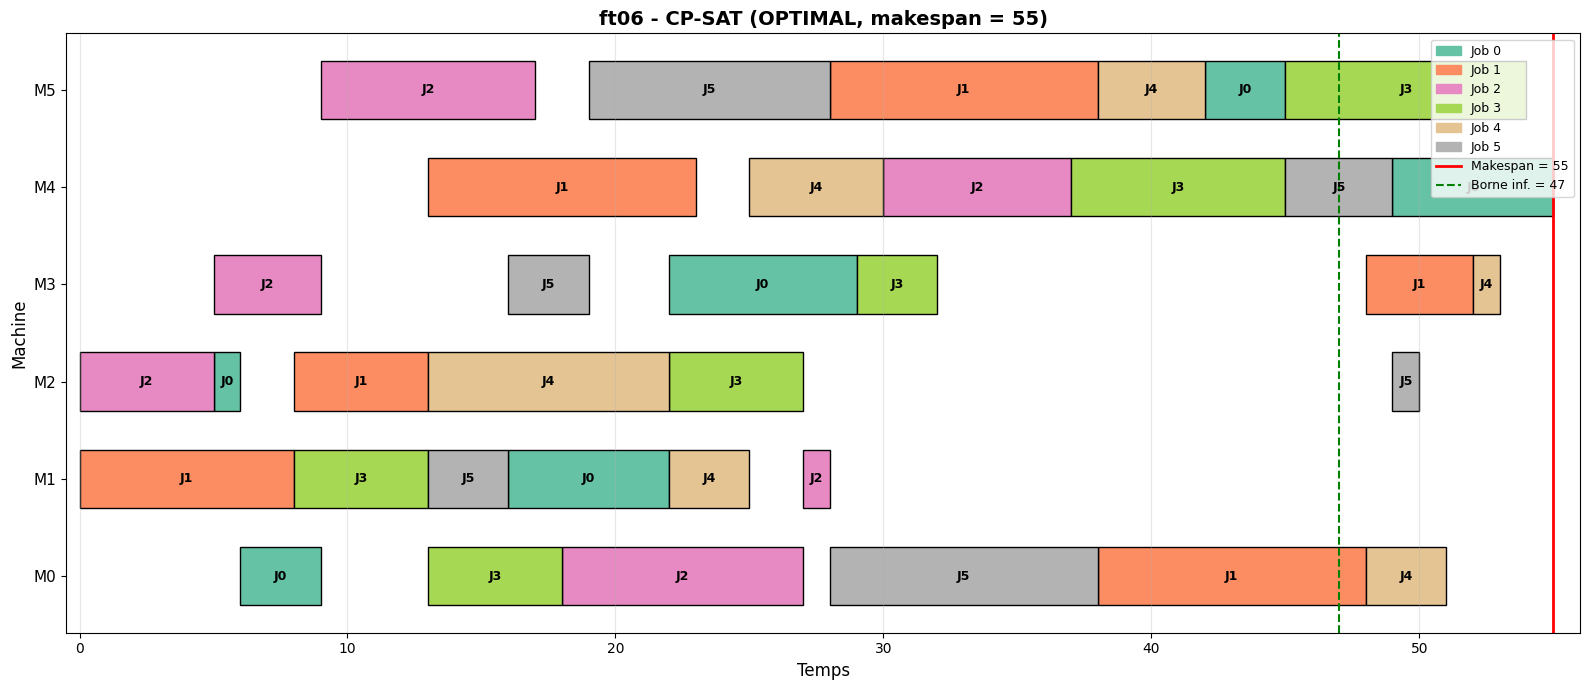

In [14]:
# Gantt de la solution CP-SAT pour ft06
if schedule_ft06:
    draw_gantt(schedule_ft06, ft06,
               title=f'ft06 - CP-SAT ({status_ft06}, makespan = {makespan_ft06})',
               makespan=makespan_ft06, lower_bound=lb_ft06,
               figsize=(16, 7))
    plt.show()

### Instance aleatoire

Generons une instance aleatoire pour tester le passage a l'echelle.

In [15]:
def generate_random_instance(n_jobs, n_machines, min_duration=1,
                              max_duration=10, seed=42):
    """Genere une instance JSSP aleatoire.

    Chaque job visite chaque machine exactement une fois (dans un ordre aleatoire).
    """
    rng = np.random.RandomState(seed)
    jobs = []
    for j in range(n_jobs):
        machine_order = rng.permutation(n_machines).tolist()
        durations = rng.randint(min_duration, max_duration + 1, size=n_machines)
        job = [(m, int(d)) for m, d in zip(machine_order, durations)]
        jobs.append(job)

    return {
        'name': f'random_{n_jobs}x{n_machines}',
        'n_jobs': n_jobs,
        'n_machines': n_machines,
        'jobs': jobs
    }


# Instance 10 jobs x 5 machines
random_instance = generate_random_instance(10, 5, seed=42)
lb_random = describe_instance(random_instance)

Instance : random_10x5
Jobs     : 10
Machines : 5

  J0 : M1(8) -> M4(5) -> M2(7) -> M0(10) -> M3(3)  [total=33]
  J1 : M3(8) -> M1(8) -> M0(3) -> M4(6) -> M2(5)  [total=30]
  J2 : M0(2) -> M2(5) -> M4(1) -> M3(10) -> M1(6)  [total=24]
  J3 : M1(10) -> M2(3) -> M0(7) -> M3(4) -> M4(9)  [total=33]
  J4 : M1(5) -> M3(9) -> M4(7) -> M0(2) -> M2(4)  [total=27]
  J5 : M4(10) -> M2(9) -> M1(10) -> M3(5) -> M0(2)  [total=36]
  J6 : M0(7) -> M1(8) -> M2(3) -> M4(1) -> M3(4)  [total=23]
  J7 : M0(6) -> M2(6) -> M4(10) -> M3(4) -> M1(6)  [total=32]
  J8 : M0(2) -> M3(10) -> M1(4) -> M2(8) -> M4(7)  [total=31]
  J9 : M4(5) -> M2(2) -> M1(5) -> M0(8) -> M3(10)  [total=30]

Bornes inferieures :
  max(longueur job)    = 36  (job le plus long)
  max(charge machine)  = 70  (machine la plus chargee)
  Borne inferieure     = max(36, 70) = 70

Espace de recherche : (10!)^5 = 629,238,322,197,897,601,351,680,000,000,000 ordonnancements


Comparons les heuristiques et CP-SAT sur cette instance aleatoire.

In [16]:
# Resolution de l'instance aleatoire
print("\nHeuristiques :")
best_heuristic_name = None
best_heuristic_makespan = float('inf')

for rule in rules:
    _, makespan_h = dispatching_scheduler(random_instance, rule)
    print(f"  {rule:<6} : makespan = {makespan_h}")
    if makespan_h < best_heuristic_makespan:
        best_heuristic_makespan = makespan_h
        best_heuristic_name = rule

print(f"  Meilleure heuristique : {best_heuristic_name} ({best_heuristic_makespan})")

print(f"\nCP-SAT (limite 30s) :")
schedule_rand, makespan_rand, status_rand, time_rand = solve_jssp_cpsat(
    random_instance, time_limit_s=30
)

if schedule_rand and makespan_rand:
    improvement = (best_heuristic_makespan - makespan_rand) / best_heuristic_makespan * 100
    print(f"\nAmelioration CP-SAT vs meilleure heuristique : {improvement:.1f}%")


Heuristiques :
  SPT    : makespan = 88
  LPT    : makespan = 86
  MOR    : makespan = 82
  FIFO   : makespan = 82
  Meilleure heuristique : MOR (82)

CP-SAT (limite 30s) :
Variables creees : 50 operations, horizon = 299
Contraintes de precedence : 40
Contraintes NoOverlap : 5 machines
Objectif : minimiser le makespan

Resolution en cours (limite : 30s)...

Statut   : OPTIMAL
Makespan : 70
Temps    : 37.2 ms

Amelioration CP-SAT vs meilleure heuristique : 14.6%


Visualisons la solution trouvee par CP-SAT sur l'instance aleatoire.

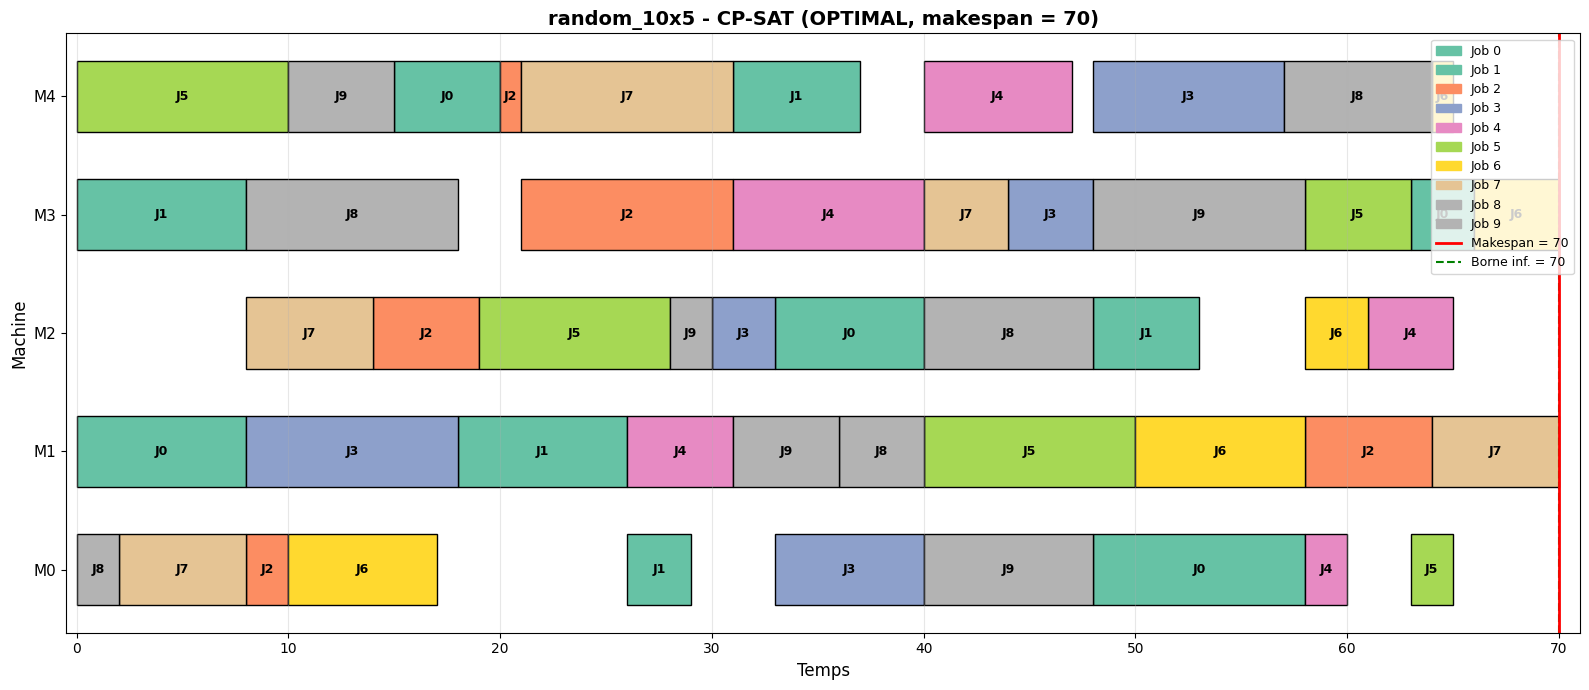

In [17]:
# Gantt de la solution CP-SAT pour l'instance aleatoire
if schedule_rand:
    draw_gantt(schedule_rand, random_instance,
               title=f'{random_instance["name"]} - CP-SAT ({status_rand}, '
                     f'makespan = {makespan_rand})',
               makespan=makespan_rand, lower_bound=lb_random,
               figsize=(16, 7))
    plt.show()

### Interpretation : passage a l'echelle

**Sortie obtenue** : sur des instances plus grandes, le solveur necessite plus de temps.

| Instance | Taille | LB | Heuristique | CP-SAT | Temps CP-SAT |
|----------|--------|------|-------------|--------|--------------|
| ft03 | 3x3 | 7 | variable | optimal | < 100 ms |
| ft06 | 6x6 | variable | variable | 55 (optimal) | < 1 s |
| random | 10x5 | variable | variable | variable | variable |

**Points cles** :
1. Le temps de resolution croit rapidement avec la taille du probleme
2. Meme sans atteindre l'optimalite prouvee, CP-SAT produit generalement de meilleures solutions que les heuristiques
3. La borne inferieure n'est pas toujours atteignable : il peut y avoir un ecart incompressible
4. Pour les instances industrielles (100+ jobs), des techniques hybrides sont necessaires

> **Note technique** : CP-SAT utilise en interne du Large Neighborhood Search (LNS) pour ameliorer la solution au fil du temps, ce qui le rend tres competitif meme avec des limites de temps strictes.

### Suivi de l'amelioration en cours de resolution

On peut observer l'evolution de la meilleure solution trouvee au cours du temps grace a un **callback** du solveur.

In [18]:
class SolutionLogger(cp_model.CpSolverSolutionCallback):
    """Callback pour enregistrer l'amelioration de la solution."""

    def __init__(self, makespan_var):
        super().__init__()
        self.makespan_var = makespan_var
        self.solutions = []  # (time, makespan)
        self.start_time = time.time()

    def on_solution_callback(self):
        elapsed = time.time() - self.start_time
        makespan = self.Value(self.makespan_var)
        self.solutions.append((elapsed, makespan))


def solve_with_logging(instance, time_limit_s=10):
    """Resoud et enregistre l'amelioration de la solution."""
    jobs = instance['jobs']
    n_jobs = instance['n_jobs']
    n_machines = instance['n_machines']

    model = cp_model.CpModel()
    horizon = sum(d for job in jobs for _, d in job)

    starts, ends, intervals = {}, {}, {}
    machine_intervals = defaultdict(list)

    for j, job in enumerate(jobs):
        for k, (machine, duration) in enumerate(job):
            suffix = f'_j{j}_o{k}'
            s = model.NewIntVar(0, horizon, f'start{suffix}')
            e = model.NewIntVar(0, horizon, f'end{suffix}')
            iv = model.NewIntervalVar(s, duration, e, f'interval{suffix}')
            starts[(j, k)] = s
            ends[(j, k)] = e
            intervals[(j, k)] = iv
            machine_intervals[machine].append(iv)

    for j, job in enumerate(jobs):
        for k in range(len(job) - 1):
            model.Add(ends[(j, k)] <= starts[(j, k + 1)])

    for m in range(n_machines):
        model.AddNoOverlap(machine_intervals[m])

    makespan_var = model.NewIntVar(0, horizon, 'makespan')
    for j, job in enumerate(jobs):
        model.Add(makespan_var >= ends[(j, len(job) - 1)])
    model.Minimize(makespan_var)

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit_s

    logger = SolutionLogger(makespan_var)
    status = solver.Solve(model, logger)

    return logger.solutions, solver.StatusName(status)


# Suivi sur l'instance aleatoire
solutions_log, final_status = solve_with_logging(random_instance, time_limit_s=10)

print(f"Statut final : {final_status}")
print(f"Solutions intermediaires : {len(solutions_log)}")
for t, ms in solutions_log:
    print(f"  t = {t:.3f}s -> makespan = {ms}")

Statut final : OPTIMAL
Solutions intermediaires : 3
  t = 0.015s -> makespan = 72
  t = 0.018s -> makespan = 71
  t = 0.020s -> makespan = 70


Tracons la courbe d'amelioration de la solution au fil du temps.

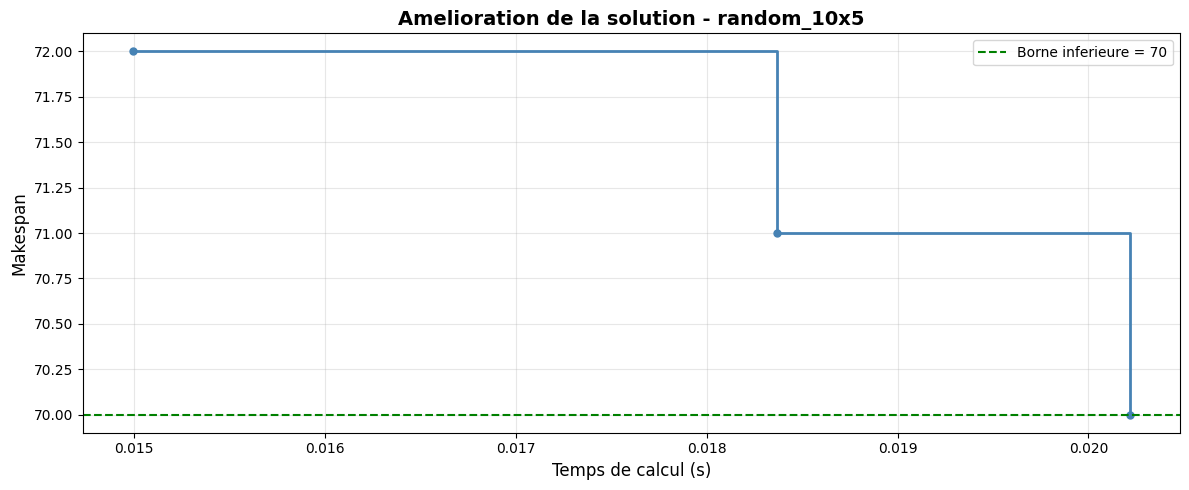

In [19]:
# Graphique d'amelioration de la solution
if solutions_log:
    times = [t for t, _ in solutions_log]
    makespans = [ms for _, ms in solutions_log]

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.step(times, makespans, where='post', linewidth=2, color='steelblue',
            marker='o', markersize=5)

    ax.axhline(y=lb_random, color='green', linestyle='--', linewidth=1.5,
               label=f'Borne inferieure = {lb_random}')

    ax.set_xlabel('Temps de calcul (s)', fontsize=12)
    ax.set_ylabel('Makespan', fontsize=12)
    ax.set_title(f'Amelioration de la solution - {random_instance["name"]}',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Aucune solution intermediaire enregistree.")

### Interpretation : courbe d'amelioration

**Sortie obtenue** : le graphique montre l'evolution du makespan au fil du temps.

**Points cles** :
1. Les ameliorations les plus importantes surviennent dans les premieres secondes
2. La courbe forme un "escalier" decroissant : chaque palier est une solution ameliorante
3. L'ecart avec la borne inferieure se reduit mais ne l'atteint pas toujours
4. Apres quelques secondes, les ameliorations deviennent marginales (rendements decroissants)

> **Regle pratique** : pour les instances industrielles, allouer 10-30 secondes au solveur donne generalement 90% de l'amelioration totale possible.

---

## 6. Extension multi-objectif (~8 min)

Dans les problemes d'ordonnancement reels, le makespan n'est pas le seul critere. On souhaite souvent minimiser simultanement :

- **Makespan** ($C_{\max}$) : temps d'achevement total
- **Retard total** ($\sum T_j$) : somme des retards par rapport aux dates d'echeance

### Modelisation avec dates d'echeance

On ajoute a chaque job $J_j$ une **date d'echeance** (*due date*) $d_j$. Le **retard** est :
$$T_j = \max(0, C_j - d_j)$$

ou $C_j$ est le temps d'achevement du job $J_j$.

### Objectif pondere

On utilise un objectif pondere combinant les deux criteres :
$$\text{Minimiser } w_1 \cdot C_{\max} + w_2 \cdot \sum_{j} T_j$$

En faisant varier les poids $w_1$ et $w_2$, on explore differents compromis.

In [20]:
def solve_jssp_multi_objective(instance, due_dates, w_makespan=1, w_tardiness=1,
                                time_limit_s=30):
    """Resoud un JSSP multi-objectif (makespan + retard).

    Parametres:
        instance : dict standard JSSP
        due_dates : list de dates d'echeance par job
        w_makespan : poids du makespan dans l'objectif
        w_tardiness : poids du retard total dans l'objectif
    """
    jobs = instance['jobs']
    n_jobs = instance['n_jobs']
    n_machines = instance['n_machines']

    model = cp_model.CpModel()
    horizon = sum(d for job in jobs for _, d in job) * 2  # Marge pour les retards

    starts, ends, intervals = {}, {}, {}
    machine_intervals = defaultdict(list)

    for j, job in enumerate(jobs):
        for k, (machine, duration) in enumerate(job):
            suffix = f'_j{j}_o{k}'
            s = model.NewIntVar(0, horizon, f'start{suffix}')
            e = model.NewIntVar(0, horizon, f'end{suffix}')
            iv = model.NewIntervalVar(s, duration, e, f'interval{suffix}')
            starts[(j, k)] = s
            ends[(j, k)] = e
            intervals[(j, k)] = iv
            machine_intervals[machine].append(iv)

    # Precedence intra-job
    for j, job in enumerate(jobs):
        for k in range(len(job) - 1):
            model.Add(ends[(j, k)] <= starts[(j, k + 1)])

    # NoOverlap par machine
    for m in range(n_machines):
        model.AddNoOverlap(machine_intervals[m])

    # Makespan
    makespan_var = model.NewIntVar(0, horizon, 'makespan')
    for j, job in enumerate(jobs):
        model.Add(makespan_var >= ends[(j, len(job) - 1)])

    # Retard par job : tardiness_j = max(0, completion_j - due_date_j)
    tardiness_vars = []
    for j, job in enumerate(jobs):
        completion = ends[(j, len(job) - 1)]
        tardiness = model.NewIntVar(0, horizon, f'tardiness_{j}')
        model.Add(tardiness >= completion - due_dates[j])
        model.Add(tardiness >= 0)
        tardiness_vars.append(tardiness)

    total_tardiness = model.NewIntVar(0, horizon * n_jobs, 'total_tardiness')
    model.Add(total_tardiness == sum(tardiness_vars))

    # Objectif pondere
    model.Minimize(w_makespan * makespan_var + w_tardiness * total_tardiness)

    # Resolution
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit_s
    start_time = time.time()
    status = solver.Solve(model)
    solve_time = (time.time() - start_time) * 1000

    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        schedule = {}
        for j, job in enumerate(jobs):
            for k, (machine, duration) in enumerate(job):
                s = solver.Value(starts[(j, k)])
                e = solver.Value(ends[(j, k)])
                schedule[(j, k)] = (s, e, machine)

        return {
            'schedule': schedule,
            'makespan': solver.Value(makespan_var),
            'total_tardiness': solver.Value(total_tardiness),
            'tardiness_per_job': [solver.Value(t) for t in tardiness_vars],
            'status': solver.StatusName(status),
            'time_ms': solve_time,
            'objective': solver.ObjectiveValue()
        }
    else:
        return None


print("Fonction solve_jssp_multi_objective definie.")

Fonction solve_jssp_multi_objective definie.


Definissons des dates d'echeance pour ft06 et explorons l'impact des differentes ponderations.

In [21]:
# Definir des dates d'echeance pour ft06
# Heuristique : due_date = sum(durees du job) * facteur
ft06_due_dates = []
for job in ft06['jobs']:
    total = sum(d for _, d in job)
    ft06_due_dates.append(int(total * 1.8))  # Facteur de tolerance 1.8

print("Dates d'echeance pour ft06 :")
for j, (dd, job) in enumerate(zip(ft06_due_dates, ft06['jobs'])):
    total = sum(d for _, d in job)
    print(f"  J{j} : duree totale = {total}, echeance = {dd}")

# Tester differentes combinaisons de poids
weight_configs = [
    (1, 0, "Makespan seul"),
    (0, 1, "Retard seul"),
    (1, 1, "Equilibre (1:1)"),
    (1, 3, "Priorite retard (1:3)"),
    (3, 1, "Priorite makespan (3:1)"),
]

multi_results = []
print(f"\n{'Poids':<25} {'Makespan':>10} {'Retard':>10} {'Objectif':>12} {'Statut':>10}")
print("-" * 70)

for w_m, w_t, label in weight_configs:
    result = solve_jssp_multi_objective(
        ft06, ft06_due_dates, w_makespan=w_m, w_tardiness=w_t,
        time_limit_s=15
    )
    if result:
        multi_results.append((label, w_m, w_t, result))
        print(f"{label:<25} {result['makespan']:>10} {result['total_tardiness']:>10}"
              f" {result['objective']:>12.0f} {result['status']:>10}")
    else:
        print(f"{label:<25} {'--':>10} {'--':>10} {'--':>12} {'INFEASIBLE':>10}")

Dates d'echeance pour ft06 :
  J0 : duree totale = 26, echeance = 46
  J1 : duree totale = 47, echeance = 84
  J2 : duree totale = 34, echeance = 61
  J3 : duree totale = 35, echeance = 63
  J4 : duree totale = 25, echeance = 45
  J5 : duree totale = 30, echeance = 54

Poids                       Makespan     Retard     Objectif     Statut
----------------------------------------------------------------------
Makespan seul                     55         17           55    OPTIMAL
Retard seul                      394          0            0    OPTIMAL


Equilibre (1:1)                   58          0           58    OPTIMAL
Priorite retard (1:3)             58          0           58    OPTIMAL
Priorite makespan (3:1)           58          0          174    OPTIMAL


Visualisons le compromis entre makespan et retard total sous forme de nuage de points.

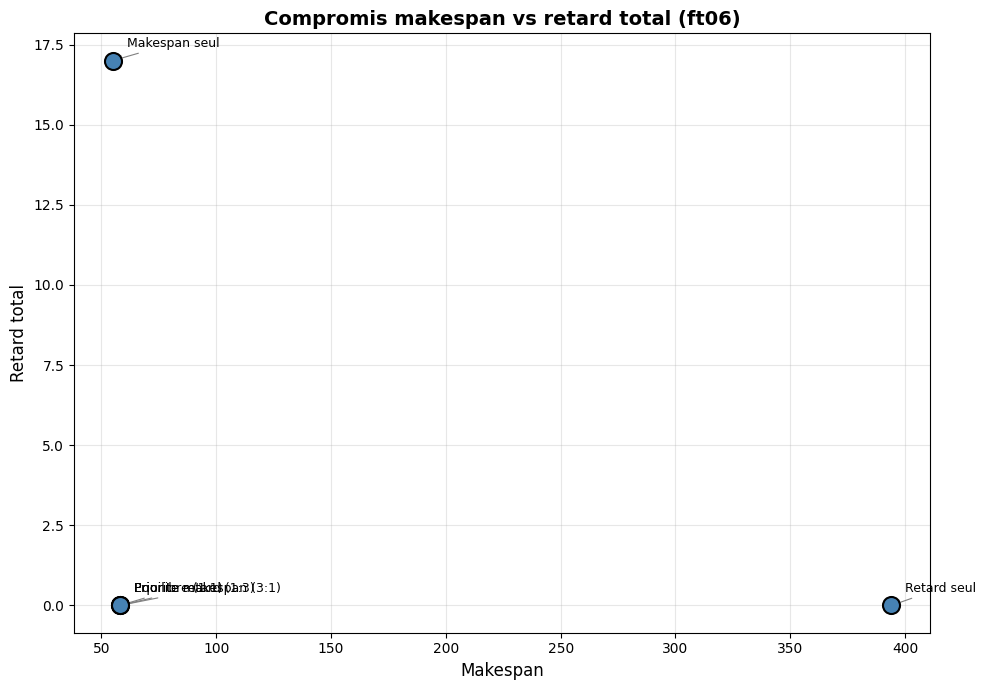

In [22]:
# Visualisation du compromis makespan vs retard
if len(multi_results) >= 2:
    fig, ax = plt.subplots(figsize=(10, 7))

    makespans_mo = [r[3]['makespan'] for r in multi_results]
    tardiness_mo = [r[3]['total_tardiness'] for r in multi_results]
    labels_mo = [r[0] for r in multi_results]

    ax.scatter(makespans_mo, tardiness_mo, s=150, c='steelblue',
               edgecolors='black', linewidth=1.5, zorder=5)

    for i, label in enumerate(labels_mo):
        ax.annotate(label, (makespans_mo[i], tardiness_mo[i]),
                    textcoords="offset points", xytext=(10, 10),
                    fontsize=9,
                    arrowprops=dict(arrowstyle='->', color='gray', linewidth=0.8))

    ax.set_xlabel('Makespan', fontsize=12)
    ax.set_ylabel('Retard total', fontsize=12)
    ax.set_title('Compromis makespan vs retard total (ft06)',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Interpretation : compromis multi-objectif

**Sortie obtenue** : le graphique montre le compromis entre makespan et retard total pour differentes ponderations.

| Configuration | Makespan | Retard | Commentaire |
|---------------|----------|--------|-------------|
| Makespan seul | Minimal | Potentiellement eleve | Optimise uniquement la duree totale |
| Retard seul | Potentiellement eleve | Minimal | Respecte les echeances au maximum |
| Equilibre | Compromis | Compromis | Solution de compromis raisonnable |

**Points cles** :
1. Il n'existe generalement pas de solution optimale pour les deux criteres simultanement
2. Le graphique approche un **front de Pareto** : les solutions non dominees
3. En pratique, le choix des poids depend du contexte industriel (penalites de retard, couts d'immobilisation)
4. L'objectif pondere est la methode la plus simple de scalarisation ; d'autres approches existent (epsilon-constraint, NSGA-II)

> **A retenir** : l'ordonnancement multi-objectif est au coeur des problemes industriels reels. Le JSSP mono-objectif (makespan seul) est une simplification pedagogique.

---

## 7. Recapitulatif et exercices

### Tableau recapitulatif

| Approche | Makespan | Temps | Optimalite | Usage |
|----------|----------|-------|------------|-------|
| **Dispatching Rules** (SPT, LPT, MOR) | Variable, souvent bon | < 1 ms | Non garantie | Temps reel, solution initiale |
| **CP-SAT** (OR-Tools) | Optimal ou quasi | ms a minutes | Prouvee si OPTIMAL | Planification hors ligne |
| **Multi-objectif pondere** | Depend des poids | ms a minutes | Pour chaque ponderation | Compromis industriels |

### Concepts cles

| Concept | Description |
|---------|------------|
| **Makespan** | Temps d'achevement de la derniere operation |
| **Variable d'intervalle** | Representation native (start, duration, end) dans CP-SAT |
| **NoOverlap** | Contrainte globale garantissant qu'une machine traite une seule tache a la fois |
| **Borne inferieure** | max(longueur du plus long job, charge de la machine la plus chargee) |
| **Diagramme de Gantt** | Visualisation standard des ordonnancements |
| **Front de Pareto** | Ensemble des solutions non dominees en multi-objectif |

### Exercice 1 : Implementer la regle LPT

**Enonce** : implementez la regle **LPT** (Longest Processing Time) et comparez ses performances avec SPT sur l'instance ft06.

**Indice** : la regle LPT est identique a SPT mais trie par duree decroissante au lieu de croissante.

In [23]:
# Exercice 1 : Comparaison SPT vs LPT sur ft06

# A COMPLETER
# La fonction dispatching_scheduler supporte deja 'LPT'.
# Comparez les makespan et tracez les deux Gantt cote a cote.

# schedule_spt, ms_spt = dispatching_scheduler(ft06, 'SPT')
# schedule_lpt, ms_lpt = dispatching_scheduler(ft06, 'LPT')
# print(f"SPT : makespan = {ms_spt}")
# print(f"LPT : makespan = {ms_lpt}")
# print(f"Difference : {abs(ms_spt - ms_lpt)}")

<details>
<summary><b>Solution exercice 1</b></summary>

```python
schedule_spt, ms_spt = dispatching_scheduler(ft06, 'SPT')
schedule_lpt, ms_lpt = dispatching_scheduler(ft06, 'LPT')

print(f"SPT : makespan = {ms_spt}")
print(f"LPT : makespan = {ms_lpt}")
print(f"Difference : {abs(ms_spt - ms_lpt)}")
print(f"Meilleure : {'SPT' if ms_spt <= ms_lpt else 'LPT'}")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
for ax, (schedule, rule, ms) in zip(axes, [
    (schedule_spt, 'SPT', ms_spt),
    (schedule_lpt, 'LPT', ms_lpt)
]):
    colors = plt.cm.Set2(np.linspace(0, 1, ft06['n_jobs']))
    for (job, op_idx), (start, end, machine) in schedule.items():
        ax.barh(machine, end - start, left=start, height=0.6,
                color=colors[job], edgecolor='black', linewidth=1)
        ax.text(start + (end - start) / 2, machine, f"J{job}",
                ha='center', va='center', fontsize=8)
    ax.set_title(f'{rule} - Makespan = {ms}', fontweight='bold')
    ax.set_yticks(range(ft06['n_machines']))
    ax.set_yticklabels([f'M{m}' for m in range(ft06['n_machines'])])
    ax.set_xlabel('Temps')
plt.tight_layout()
plt.show()
```

</details>

### Exercice 2 : Ajouter des temps de setup

**Enonce** : dans certains ateliers, changer de job sur une machine necessite un **temps de preparation** (*setup time*). Si l'operation precedente sur la machine etait le job $i$ et la suivante est le job $j$, un setup de $s_{ij}$ unites de temps est necessaire.

Modifiez le modele CP-SAT pour inclure des temps de setup symetriques de 1 unite entre jobs differents et 0 pour le meme job.

**Indice** : utilisez des variables booleennes et `AddCircuit` ou des contraintes conditionnelles avec `OnlyEnforceIf`.

In [24]:
# Exercice 2 : JSSP avec temps de setup

# A COMPLETER
# Hint : pour chaque machine, pour chaque paire d'operations (i, j),
# creer une variable booleenne b_ij indiquant si i precede j.
# Si b_ij est vrai, alors end_i + setup_time <= start_j

# setup_time = 1  # temps de preparation entre jobs differents
# ...
# Comparez le makespan avec et sans setup times sur ft03.

<details>
<summary><b>Solution exercice 2</b></summary>

```python
def solve_jssp_with_setup(instance, setup_time=1, time_limit_s=30):
    jobs = instance['jobs']
    n_jobs = instance['n_jobs']
    n_machines = instance['n_machines']

    model = cp_model.CpModel()
    horizon = sum(d for job in jobs for _, d in job) + n_jobs * setup_time * n_machines

    starts, ends, intervals = {}, {}, {}
    machine_to_ops = defaultdict(list)  # machine -> [(job, op_idx, duration)]

    for j, job in enumerate(jobs):
        for k, (machine, duration) in enumerate(job):
            suffix = f'_j{j}_o{k}'
            s = model.NewIntVar(0, horizon, f'start{suffix}')
            e = model.NewIntVar(0, horizon, f'end{suffix}')
            iv = model.NewIntervalVar(s, duration, e, f'interval{suffix}')
            starts[(j, k)] = s
            ends[(j, k)] = e
            intervals[(j, k)] = iv
            machine_to_ops[machine].append((j, k, duration))

    # Precedence intra-job
    for j, job in enumerate(jobs):
        for k in range(len(job) - 1):
            model.Add(ends[(j, k)] <= starts[(j, k + 1)])

    # Pour chaque machine : disjonction avec setup times
    for m in range(n_machines):
        ops = machine_to_ops[m]
        for i in range(len(ops)):
            for j in range(i + 1, len(ops)):
                ji, ki, _ = ops[i]
                jj, kj, _ = ops[j]
                # Variable booleenne : ops[i] avant ops[j] ?
                b = model.NewBoolVar(f'order_m{m}_{ji}{ki}_{jj}{kj}')
                setup = setup_time if ji != jj else 0
                model.Add(ends[(ji, ki)] + setup <= starts[(jj, kj)]).OnlyEnforceIf(b)
                model.Add(ends[(jj, kj)] + setup <= starts[(ji, ki)]).OnlyEnforceIf(b.Not())

    makespan_var = model.NewIntVar(0, horizon, 'makespan')
    for j, job in enumerate(jobs):
        model.Add(makespan_var >= ends[(j, len(job) - 1)])
    model.Minimize(makespan_var)

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit_s
    status = solver.Solve(model)

    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        return solver.Value(makespan_var), solver.StatusName(status)
    return None, solver.StatusName(status)

ms_no_setup, _ = solve_jssp_with_setup(ft03, setup_time=0)
ms_setup_1, _ = solve_jssp_with_setup(ft03, setup_time=1)
ms_setup_2, _ = solve_jssp_with_setup(ft03, setup_time=2)

print(f"Sans setup : makespan = {ms_no_setup}")
print(f"Setup = 1  : makespan = {ms_setup_1}")
print(f"Setup = 2  : makespan = {ms_setup_2}")
```

</details>

### Exercice 3 : Flexible Job-Shop

**Enonce** : dans le **Flexible Job-Shop** (FJSP), chaque operation peut s'executer sur un sous-ensemble de machines (pas necessairement une seule). Chaque machine a potentiellement une duree differente pour la meme operation.

Modelisez un petit FJSP en utilisant des variables optionnelles (`NewOptionalIntervalVar`) et une contrainte de selection.

**Indice** : pour chaque operation, creer un intervalle optionnel par machine possible, et ajouter la contrainte `exactly_one` pour selectionner une seule machine.

In [25]:
# Exercice 3 : Flexible Job-Shop

# A COMPLETER
# Exemple : 2 jobs, 3 machines
# Job 0, Op 0 : peut s'executer sur M0 (duree 3) ou M1 (duree 4)
# Job 0, Op 1 : doit s'executer sur M2 (duree 2)
# Job 1, Op 0 : peut s'executer sur M0 (duree 2) ou M2 (duree 3)
# Job 1, Op 1 : doit s'executer sur M1 (duree 5)

# flexible_jobs = [
#     [[(0, 3), (1, 4)], [(2, 2)]],           # Job 0
#     [[(0, 2), (2, 3)], [(1, 5)]],            # Job 1
# ]
#
# Utilisez NewOptionalIntervalVar et AddExactlyOne pour la selection.

<details>
<summary><b>Solution exercice 3</b></summary>

```python
flexible_jobs = [
    [[(0, 3), (1, 4)], [(2, 2)]],
    [[(0, 2), (2, 3)], [(1, 5)]],
]
n_machines_flex = 3

model = cp_model.CpModel()
horizon = 30

starts, ends = {}, {}
machine_intervals = defaultdict(list)

for j, job in enumerate(flexible_jobs):
    for k, alternatives in enumerate(job):
        # Variables communes
        s = model.NewIntVar(0, horizon, f'start_j{j}_o{k}')
        e = model.NewIntVar(0, horizon, f'end_j{j}_o{k}')
        starts[(j, k)] = s
        ends[(j, k)] = e

        # Si une seule machine possible, pas d'alternative
        if len(alternatives) == 1:
            m, d = alternatives[0]
            iv = model.NewIntervalVar(s, d, e, f'interval_j{j}_o{k}')
            machine_intervals[m].append(iv)
        else:
            # Variables de selection
            bools = []
            for m, d in alternatives:
                b = model.NewBoolVar(f'sel_j{j}_o{k}_m{m}')
                bools.append(b)
                iv = model.NewOptionalIntervalVar(
                    s, d, e, b, f'interval_j{j}_o{k}_m{m}')
                machine_intervals[m].append(iv)
            model.AddExactlyOne(bools)

    # Precedence intra-job
    for k in range(len(job) - 1):
        model.Add(ends[(j, k)] <= starts[(j, k + 1)])

# NoOverlap par machine
for m in range(n_machines_flex):
    if machine_intervals[m]:
        model.AddNoOverlap(machine_intervals[m])

# Makespan
makespan_var = model.NewIntVar(0, horizon, 'makespan')
for j, job in enumerate(flexible_jobs):
    model.Add(makespan_var >= ends[(j, len(job) - 1)])
model.Minimize(makespan_var)

solver = cp_model.CpSolver()
status = solver.Solve(model)
if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print(f"Makespan optimal FJSP : {solver.Value(makespan_var)}")
```

</details>

### Pour aller plus loin

| Sujet | Description | Lien |
|-------|-------------|------|
| **Timetabling** | Variante du JSSP avec contraintes de salle et de professeur | [App-5 Timetabling](App-5-Timetabling.ipynb) |
| **Nurse Scheduling** | Ordonnancement de personnel (contraintes soft/hard) | [App-3 NurseScheduling](App-3-NurseScheduling.ipynb) |
| **MiniZinc** | Langage de modelisation declaratif pour l'ordonnancement | [App-8 MiniZinc](App-8-MiniZinc.ipynb) |
| **LNS** | Large Neighborhood Search pour les grandes instances | [Search-8 CSP Advanced](../Foundations/Search-8-CSP-Advanced.ipynb) |

### References

- Pinedo, M. *Scheduling: Theory, Algorithms, and Systems*, Springer, 2016
- OR-Tools documentation : [Scheduling](https://developers.google.com/optimization/scheduling)
- Benchmark instances : [OR-Library](http://people.brunel.ac.uk/~mastjjb/jeb/orlib/jobshopinfo.html)
- Projet etudiant : [jsboigeEpita/2025-PPC](https://github.com/jsboigeEpita/2025-PPC)

---

**Navigation** : [<< App-3 NurseScheduling](App-3-NurseScheduling.ipynb) | [Index](../README.md) | [App-5 Timetabling >>](App-5-Timetabling.ipynb)